In [1]:
import pandas as pd
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore') # hide annoying DeprecationWarning 

# Grenzen und ZonenID an Netz

## input
* Zonen einlesen
* Netzwerk einlesen

## get all Network links on border
* dissolve zonen-layer
* get only border of dissolved zonen-layer
* sjoin net and border

## Ags/Kreise 2 Links
* Links den Nuts zuordnen
* duplicate entfernen
* linklaenge hinzufuegen

## output
* shp rausschreiben
---

### Zonen einlesen

[source](https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/nuts)

In [2]:
area='EU'
    
if area=='EU':
    dic_name = 'major_streets_prim_europe_junction'

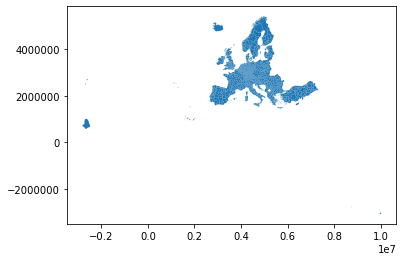

In [3]:
zones=gpd.read_file("input/NUTS_BN_03M_2016_4326_NUTS3.shp", encoding='utf8')
zones = zones.to_crs("epsg:3035")
zones.plot()

In [4]:
zones.crs

<Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - LCC & LAEA
- bounds: (-35.58, 24.6, 44.83, 84.17)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [5]:
zones.head()

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,_count,_sum,_mean,area,geometry
0,3,FRK23,FR,Drôme,FRK23,6570.0,5.058516e+05,76.994148,6568,"MULTIPOLYGON (((3974775.039 2352354.733, 39729..."
1,3,FRK24,FR,Isère,FRK24,7868.0,1.251906e+06,159.113662,7868,"MULTIPOLYGON (((3940042.115 2534830.469, 39405..."
2,3,AT313,AT,Mühlviertel,AT313,2656.0,2.041628e+05,76.868516,2658,"POLYGON ((4596341.482 2829133.808, 4597570.306..."
3,3,FI200,FI,Åland,FI200,1368.0,2.674366e+04,19.549461,1361,"MULTIPOLYGON (((4868609.423 4182783.023, 48695..."
4,3,FR102,FR,Seine-et-Marne,FR102,5940.0,1.408577e+06,237.134172,5940,"POLYGON ((3780605.063 2912395.408, 3783967.894..."


In [6]:
zones['CNTR_CODE'].unique()

array(['FR', 'AT', 'FI', 'EL', 'ES', 'TR', 'EE', 'RS', 'SE', 'SK', 'DE',
       'CH', 'BG', 'AL', 'BE', 'DK', 'CZ', 'CY', 'IT', 'PL', 'HU', 'HR',
       'PT', 'LI', 'LT', 'IE', 'RO', 'NO', 'IS', 'UK', 'SI', 'LU', 'LV',
       'ME', 'MK', 'MT', 'NL'], dtype=object)

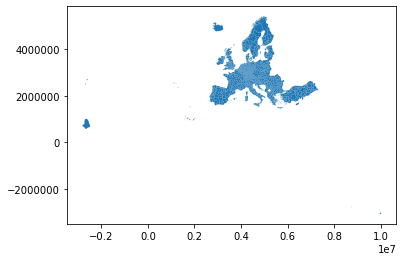

In [7]:
if area=='EU':
    zones=zones[(zones['LEVL_CODE']==3)].copy()
    zones.plot()

### Netzwerk einlesen

- [x] create base lines file

In [8]:
net = gpd.read_file('input/europe-primary-plus.gpkg', layer = 'Lines')
net.head()

,osm_id,name,highway,waterway,aerialway,barrier,man_made,oneway,maxspeed,junction,z_order,other_tags,geometry
0,73,Ballards Lane,primary,None,None,None,None,yes,30 mph,None,7,"""abutters""=>""mixed"",""lit""=>""yes"",""ref""=>""A598""...","LINESTRING (-0.17788 51.61228, -0.17785 51.61235)"
1,74,Ballards Lane,primary,None,None,None,None,None,30 mph,None,7,"""abutters""=>""retail"",""lit""=>""yes"",""ref""=>""A598...","LINESTRING (-0.19312 51.60172, -0.19297 51.60186)"
2,75,High Road,primary,None,None,None,None,None,30 mph,None,7,"""lit""=>""yes"",""ref""=>""A1000"",""abutters""=>""retail""","LINESTRING (-0.17679 51.61732, -0.17679 51.616..."
3,79,East End Road,primary,None,None,None,None,None,30 mph,None,7,"""lit""=>""yes"",""ref""=>""A504""","LINESTRING (-0.19799 51.59712, -0.19778 51.596..."
4,188,Marsh Lane,primary,None,None,None,None,yes,30 mph,None,7,"""cycleway""=>""opposite_track"",""cycleway:left""=>...","LINESTRING (-1.39698 50.90121, -1.39690 50.901..."


In [9]:
net['highway'].unique()

array(['primary', 'trunk', 'motorway_link', 'motorway', 'trunk_link',
       'primary_link', 'secondary', 'residential', 'unclassified',
       'tertiary', 'living_street', 'service', 'secondary_link', None],
      dtype=object)

In [10]:
# filter highway types
net = net[net['highway'].isin(['motorway', 'motorway_link', 'trunk', 'trunk_link', 'primary', 'primary_link'])].copy()
net['highway'].unique()

array(['primary', 'trunk', 'motorway_link', 'motorway', 'trunk_link',
       'primary_link'], dtype=object)

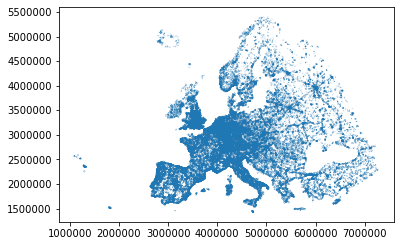

In [11]:
net = net.to_crs('epsg:3035') 
net[::10].plot()

---

## get all Network links on border

* dissolve zonen-layer
* get only border of dissolved zonen-layer
* sjoin net and border

### dissolve krs-layer

In [12]:
# dissolve
zones_dis = zones.copy()
zones_dis['all']=1
zone_full = zones_dis.dissolve(by='all', aggfunc='sum').copy()
zone_full.head()
#zone_full.plot()

,geometry,LEVL_CODE,_count,_sum,_mean,area
all,,,,,,
1,"MULTIPOLYGON (((10004004.326 -3022294.871, 100...",4566,5854880.0,6.068201e+08,811673.613286,5863367


### get only border of dissolved krs-layer

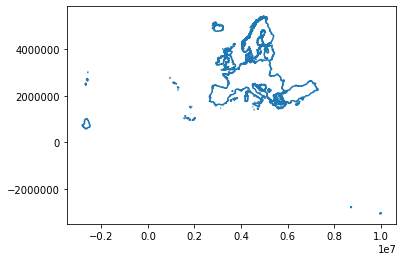

In [13]:
grenzen=zone_full.copy()
grenzen['geometry']= zone_full['geometry'].boundary
grenzen['geometry'][:1].values[0]=grenzen['geometry'][:1].values[0].simplify(40, preserve_topology=True) #simplify
grenzen.plot()

### sjoin net and border

In [15]:
sjoin_grenzen_net=gpd.sjoin(grenzen[['geometry']], net, how='inner', op='intersects')

In [16]:
grenz_links=net[net['osm_id'].isin(sjoin_grenzen_net['osm_id'])]
grenz_links.head()

,osm_id,name,highway,waterway,aerialway,barrier,man_made,oneway,maxspeed,junction,z_order,other_tags,geometry
110,1637,Rosslandsvegen,primary,None,None,None,None,None,70,None,7,"""ref""=>""564"",""surface""=>""paved""","LINESTRING (4059594.951 4167480.100, 4059588.9..."
111,1641,None,trunk_link,None,None,None,None,yes,80,None,8,"""bicycle""=>""no"",""foot""=>""no"",""lanes""=>""1"",""ref...","LINESTRING (4060026.325 4167819.275, 4060036.5..."
152,2097,Dunglass Roundabout,trunk,None,None,None,None,None,70 mph,roundabout,8,"""lit""=>""yes"",""lanes""=>""2"",""operator""=>""Transpo...","LINESTRING (3421059.666 3738734.290, 3421055.7..."
153,2098,Dumbarton Road,trunk,None,None,None,None,yes,70 mph,None,8,"""lanes""=>""2"",""lit""=>""yes"",""maxspeed:type""=>""GB...","LINESTRING (3421055.761 3738736.928, 3421028.7..."
154,2099,Dumbarton Road,trunk,None,None,None,None,yes,40 mph,None,8,"""lanes""=>""2"",""lit""=>""yes"",""operator""=>""Transpo...","LINESTRING (3419701.105 3739411.072, 3419729.1..."


In [17]:
# add border attribute to net_df
net_g=net.copy()

net_g['grenze']=0
net_g.loc[net_g['osm_id'].isin(sjoin_grenzen_net.osm_id), 'grenze'] = 1

#net_g.grenze.value_counts()

In [18]:
len(net_g)

2251854

In [19]:
sum(net_g['grenze'])

3909

## ZonenID 2 Links
* Links den Zonen zuordnen
* duplicate entfernen
* linklaenge hinzufuegen

In [20]:
zones.head()

,LEVL_CODE,NUTS_ID,CNTR_CODE,NUTS_NAME,FID,_count,_sum,_mean,area,geometry
0,3,FRK23,FR,Drôme,FRK23,6570.0,5.058516e+05,76.994148,6568,"MULTIPOLYGON (((3974775.039 2352354.733, 39729..."
1,3,FRK24,FR,Isère,FRK24,7868.0,1.251906e+06,159.113662,7868,"MULTIPOLYGON (((3940042.115 2534830.469, 39405..."
2,3,AT313,AT,Mühlviertel,AT313,2656.0,2.041628e+05,76.868516,2658,"POLYGON ((4596341.482 2829133.808, 4597570.306..."
3,3,FI200,FI,Åland,FI200,1368.0,2.674366e+04,19.549461,1361,"MULTIPOLYGON (((4868609.423 4182783.023, 48695..."
4,3,FR102,FR,Seine-et-Marne,FR102,5940.0,1.408577e+06,237.134172,5940,"POLYGON ((3780605.063 2912395.408, 3783967.894..."


In [21]:
sjoin_zone_net=gpd.sjoin(zones[['geometry','NUTS_ID']], net_g, how='inner', op='intersects')

In [22]:
# frequency of ids ( lines in more than 1 AGS)
sjoin_zone_net['freq_osmid'] = sjoin_zone_net.groupby('osm_id')['osm_id'].transform('size')
sjoin_zone_net['freq_osmid'].value_counts()

1    2071249
2      31680
3        273
Name: freq_osmid, dtype: int64

drop duplicates ids

In [23]:
sjoin_zone_net= sjoin_zone_net.drop_duplicates(subset=['osm_id'], keep='first', inplace=False)
sjoin_zone_net['freq_osmid'] = sjoin_zone_net.groupby('osm_id')['osm_id'].transform('size')
sjoin_zone_net['freq_osmid'].value_counts()

1    2087180
Name: freq_osmid, dtype: int64

In [24]:
sjoin_zone_net[['osm_id','NUTS_ID']].head()

,osm_id,NUTS_ID
0,354710240,FRK23
0,354710241,FRK23
0,22141159,FRK23
0,22141155,FRK23
0,517328937,FRK23


In [25]:
net_done=pd.merge(net_g,sjoin_zone_net[['osm_id','NUTS_ID']])

Add line length

In [26]:
net_done['geom_len']=net_done['geometry'].apply(lambda x: int(round(x.length)))

In [27]:
net_done.head(5)

,osm_id,name,highway,waterway,aerialway,barrier,man_made,oneway,maxspeed,junction,z_order,other_tags,geometry,grenze,NUTS_ID,geom_len
0,73,Ballards Lane,primary,None,None,None,None,yes,30 mph,None,7,"""abutters""=>""mixed"",""lit""=>""yes"",""ref""=>""A598""...","LINESTRING (3618620.553 3215959.506, 3618623.9...",0,UKI71,8
1,74,Ballards Lane,primary,None,None,None,None,None,30 mph,None,7,"""abutters""=>""retail"",""lit""=>""yes"",""ref""=>""A598...","LINESTRING (3617413.294 3214941.334, 3617425.6...",0,UKI71,18
2,75,High Road,primary,None,None,None,None,None,30 mph,None,7,"""lit""=>""yes"",""ref""=>""A1000"",""abutters""=>""retail""","LINESTRING (3618773.573 3216504.927, 3618765.8...",0,UKI71,62
3,79,East End Road,primary,None,None,None,None,None,30 mph,None,7,"""lit""=>""yes"",""ref""=>""A504""","LINESTRING (3617008.948 3214480.394, 3617021.0...",0,UKI71,674
4,188,Marsh Lane,primary,None,None,None,None,yes,30 mph,None,7,"""cycleway""=>""opposite_track"",""cycleway:left""=>...","LINESTRING (3522979.626 3150106.869, 3522984.4...",0,UKJ32,151


In [28]:
net_done.columns

Index(['osm_id', 'name', 'highway', 'waterway', 'aerialway', 'barrier',
       'man_made', 'oneway', 'maxspeed', 'junction', 'z_order', 'other_tags',
       'geometry', 'grenze', 'NUTS_ID', 'geom_len'],
      dtype='object')

In [29]:
net_done=net_done[['osm_id', 'highway', 'oneway', 'junction', 'geometry', 'grenze', 'NUTS_ID', 'geom_len']].copy()

## rausschreiben 

In [61]:
#net_done = net_done.to_crs("epsg:4326")

In [106]:
net_done.head()

,osm_id,highway,oneway,junction,geometry,grenze,NUTS_ID,geom_len
0,73,primary,yes,None,"LINESTRING (3618620.553 3215959.506, 3618623.9...",0,UKI71,8
1,74,primary,None,None,"LINESTRING (3617413.294 3214941.334, 3617425.6...",0,UKI71,18
2,75,primary,None,None,"LINESTRING (3618773.573 3216504.927, 3618765.8...",0,UKI71,62
3,79,primary,None,None,"LINESTRING (3617008.948 3214480.394, 3617021.0...",0,UKI71,674
4,188,primary,yes,None,"LINESTRING (3522979.626 3150106.869, 3522984.4...",0,UKJ32,151


In [30]:
net_done.groupby('highway')['geom_len'].sum()

highway
motorway         166577240
motorway_link     36297457
primary          362010530
primary_link       8328149
trunk            177122989
trunk_link        18971311
Name: geom_len, dtype: int64

In [31]:
net_done.groupby('highway')['osm_id'].count()

highway
motorway          262856
motorway_link     190173
primary          1069361
primary_link       98664
trunk             332074
trunk_link        134052
Name: osm_id, dtype: int64

## Kontrolle & Export

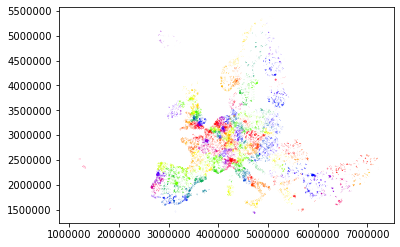

In [32]:
net_done[::100].plot(column='NUTS_ID', cmap='prism')#, legend=True)

In [33]:
net_done.to_file('input/lines-border-nutsid.gpkg', driver = 'GPKG')

---